In [2]:
import csv
from collections import defaultdict, Counter
from itertools import combinations
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import sklearn.metrics as metrics

# Load data

In [3]:
class Child():
    def __init__(self, data):
        self.id = data[1]
        self.family = data[0]
        self.relatedness = data[2]
        self.sex = data[5]
        self.age = None if data[6]=='' or int(data[6])<0 or int(data[6])>100 else int(data[6])
        self.diagnoses = set(data[7].split(','))
        self.is_asd = data[8]=='yes'
        
        self.attrs = ['yes' in data[9], int(data[11])>7] + ['yes' in x for x in data[12:21]]
        self.SCQ = None
        
    def __str__(self):
        return 'Child(id=%s, fam=%s)' % (self.id, self.family)

children = list()
fam_to_children = defaultdict(list)
with open('../data/kfPedsFileExport_09-12-2022.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    header = [header[9]] + header[11:21]
    for line in reader:
        child = Child(line)
        children.append(child)
        
child_id_to_index = dict([(child.id, i) for i, child in enumerate(children)])
with open('../data/kidsFirstAdminExport_09-20-2022_SCQ.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    scq_header = next(reader)[20:60]
    next(reader)
    next(reader)
    next(reader)
    for line in reader:
        child_id = line[0]
        if child_id in child_id_to_index:
            children[child_id_to_index[child_id]].SCQ = [None if x=='' else x=='1' for x in line[20:60]]

children = [child for child in children if child.SCQ is not None]
for child in children:
    fam_to_children[child.family].append(child)

print(len(fam_to_children))

714


In [4]:
child_to_index = dict([(child.id, i) for i, child in enumerate(children)])

In [5]:
print(set(sum([[x.relatedness for x in children] for children in fam_to_children.values()], [])))

{'unrelated', 'stepmother', 'stepfather', 'full'}


In [6]:
print(Counter([len(v) for v in fam_to_children.values()]))

Counter({1: 365, 2: 224, 3: 94, 4: 20, 5: 7, 6: 3, 7: 1})


In [7]:
print(header)

['premature', 'verbal', 'sleep', 'hearing', 'vision', 'noise', 'motor', 'metabolic', 'gi', 'infections', 'seizures']


# Correlation with autism

In [8]:
print(Counter([len(child.SCQ) for child in children]))

Counter({40: 1235})


In [9]:
attrs = np.array([x.attrs for x in children])
is_aut = np.array([child.is_asd for child in children])
scq = np.array([[False if y is None else y for y in x.SCQ] for x in children])

print(attrs.shape, scq.shape, is_aut.shape)

(1235, 11) (1235, 40) (1235,)


In [10]:
print(attrs)
print(scq)

[[False False False ... False False False]
 [ True  True False ... False False False]
 [ True  True False ... False False False]
 ...
 [False  True False ... False False False]
 [False False False ...  True  True False]
 [ True False  True ... False False False]]
[[ True  True  True ... False False False]
 [ True  True False ...  True  True  True]
 [ True  True False ...  True  True  True]
 ...
 [ True  True False ...  True  True  True]
 [False False False ...  True False False]
 [False False False ...  True False False]]


In [11]:
pvalues = np.ones((11,))
for i in range(11):
    pvalues[i] = stats.chi2_contingency([[np.sum(attrs[is_aut, i]), np.sum(attrs[~is_aut, i])],
                                         [np.sum(~attrs[is_aut, i]), np.sum(~attrs[~is_aut, i])]])[1]
    
pvalues_scq = np.ones((40,))
for i in range(40):
    pvalues_scq[i] = stats.chi2_contingency([[np.sum(scq[is_aut, i]), np.sum(scq[~is_aut, i])],
                                         [np.sum(~scq[is_aut, i]), np.sum(~scq[~is_aut, i])]])[1]

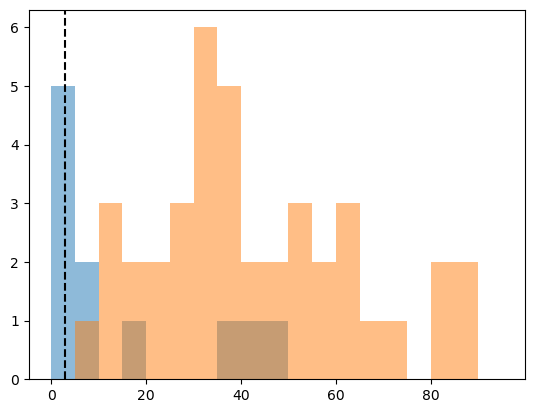

In [12]:
plt.hist(-np.log10(pvalues), bins=np.arange(0, 100, 5), alpha=0.5)
plt.hist(-np.log10(pvalues_scq), bins=np.arange(0, 100, 5), alpha=0.5)
plt.axvline(-np.log10(0.05/(40+11)), color='black', linestyle='--')
plt.show()

In [16]:
for attr, p in zip(header, pvalues):
    if p<0.05/(11):
        print(attr, p*(11))
        
# verbal, sleep, noise, motor, gi, infections
# add metabolic, seizure

# only gi and infections overlap with heritable independent of autism
print(np.max(pvalues_scq)*40)

verbal 6.080849210959143e-48
sleep 3.422856948720025e-16
noise 6.748013309874e-41
motor 1.6854594584382025e-35
metabolic 0.047143285695275906
gi 4.531622431062701e-09
infections 1.0750311834031193e-05
seizures 0.019832919782411695
2.177720133505907e-08


# Predict autism

In [40]:
# split into train and test (10%) by family
is_train = np.ones((len(children),), dtype=bool)
for fam, cs in fam_to_children.items():
    if random.random() < 0.1:
        for child in cs:
            if child.id in child_to_index:
                is_train[child_to_index[child.id]] = False
                
offset = np.ones((len(children), 1))
                
print('train', np.sum(is_train), 'test', np.sum(~is_train))

train 1111 test 124


In [46]:
# Here, we're using a logistic regression model, regularized with L1 regression (meaning we encourage the model to
# use as few features as possible). The regularization means we need to tune a parameter alpha, which we do through
# cross validation.

# this is our L1-regularized logistic regression model
def train_logreg_l1_model(y, data, alpha):
    model = sm.Logit(y, data)
    result = model.fit_regularized(method='l1_cvxopt_cp', alpha=alpha, disp=False)
    
    if not result.mle_retvals["converged"]:
        result = None
        
    return result

# here, we pick the alpha which produces the best AUROC (area under the ROC curve) in cross validation.
def tune_params(y, data, train_model, alphas=[0.1, 0.5, 1, 5, 10, 50]):
    # 10-fold cross-validation
    num_folds=10
    folds = np.random.randint(0, num_folds, size=(len(y),))
    rocs = np.zeros((len(alphas), num_folds))
    nonzero_params = np.zeros((len(alphas), num_folds))
    for i, alpha in enumerate(alphas):
        for fold in range(num_folds):
            result = train_model(y[folds!=fold], data[folds!=fold, :], alpha)
            if hasattr(result, 'params'):
                params = result.params
            else:
                params = result.coef_
            if result is not None:
                rocs[i, fold] = metrics.roc_auc_score(y[folds==fold], result.predict(data[folds==fold, :]))
                nonzero_params[i, fold] = np.sum(~np.isclose(params, 0))
            else:
                rocs[i, fold] = np.nan
                nonzero_params[i, fold] = np.nan
        print(alpha, nonzero_params[i, :])
        
    best_alpha = alphas[np.nanargmax(np.nanmedian(rocs, axis=1))]
    print(best_alpha, np.nanmedian(rocs, axis=1))
    
    return best_alpha

In [47]:
# for every attribute, we train classifiers using only training data

X_attr = np.hstack((offset, attrs))
alpha_attr = tune_params(is_aut[is_train], X_attr[is_train, :], train_logreg_l1_model)

X_scq = np.hstack((offset, scq))
alpha_scq = tune_params(is_aut[is_train], X_scq[is_train, :], train_logreg_l1_model)

X_attrscq = np.hstack((offset, attrs, scq))
alpha_attrscq = tune_params(is_aut[is_train], X_attrscq[is_train, :], train_logreg_l1_model)

0.1 [12. 11. 12. 12. 12. 11. 12. 12. 11. 12.]
0.5 [12. 11. 11. 12. 12. 11. 11. 12. 11. 12.]
1 [12. 10. 10. 12. 12. 10. 11. 11. 11. 11.]
5 [7. 9. 8. 8. 6. 7. 7. 7. 9. 8.]
10 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
50 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
5 [0.79613617 0.79629566 0.79789056 0.80956843 0.80451318 0.80168129]
0.1 [41. 41. 41. 40. 41. 41. 41. 40. 41. 41.]
0.5 [36. 36. 40. 39. 39. 41. 40. 37. 38. 37.]
1 [35. 34. 38. 35. 36. 40. 35. 34. 38. 34.]
5 [28. 28. 26. 26. 29. 28. 29. 26. 29. 27.]
10 [26. 24. 23. 25. 27. 26. 26. 25. 25. 25.]
50 [11. 10.  9. 10. 11. 11. 12. 10. 11. 10.]
0.5 [0.92505192 0.92750541 0.92708822 0.92487686 0.92230667 0.91881021]
0.1 [52. 52. 52. 51. 51. 51. 52. 51. 52. 52.]
0.5 [48. 50. 48. 50. 50. 47. 47. 51. 47. 50.]
1 [44. 48. 44. 47. 48. 45. 45. 49. 45. 47.]
5 [32. 32. 30. 28. 30. 29. 28. 33. 31. 30.]
10 [26. 27. 25. 27. 29. 27. 28. 27. 27. 27.]
50 [11. 11. 11. 11. 12. 10. 11. 12. 11. 10.]
1 [0.94323223 0.94366245 0.94384654 0.94152902 0.93927894 0.93219026]


In [48]:
print(alpha_attr, alpha_scq, alpha_attrscq)

5 0.5 1


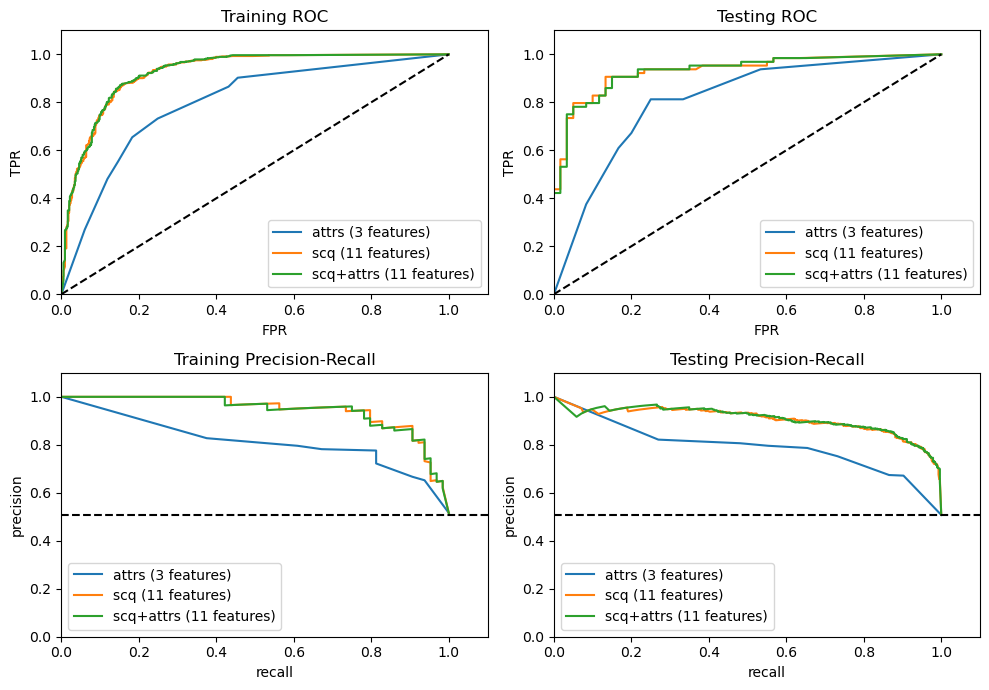

In [53]:
# now plot the data
plt.figure(figsize=(10, 7))

result_attr = train_logreg_l1_model(is_aut[is_train], X_attr[is_train, :], 50)
result_scq = train_logreg_l1_model(is_aut[is_train], X_scq[is_train, :], 50)
result_attrscq = train_logreg_l1_model(is_aut[is_train], X_attrscq[is_train, :], 50)
    
plt.subplot(2, 2, 1)
fpr, tpr, _ = metrics.roc_curve(is_aut[is_train], result_attr.predict(X_attr[is_train, :]))
plt.plot(fpr, tpr, label='attrs (%d features)' % np.sum(~np.isclose(result_attr.params, 0)))

fpr, tpr, _ = metrics.roc_curve(is_aut[is_train], result_scq.predict(X_scq[is_train, :]))
plt.plot(fpr, tpr, label='scq (%d features)' % np.sum(~np.isclose(result_scq.params, 0)))
    
fpr, tpr, _ = metrics.roc_curve(is_aut[is_train], result_attrscq.predict(X_attrscq[is_train, :]))
plt.plot(fpr, tpr, label='scq+attrs (%d features)' % np.sum(~np.isclose(result_attrscq.params, 0)))
    
plt.title('Training ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend()
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])

plt.subplot(2, 2, 2)
fpr, tpr, _ = metrics.roc_curve(is_aut[~is_train], result_attr.predict(X_attr[~is_train, :]))
plt.plot(fpr, tpr, label='attrs (%d features)' % np.sum(~np.isclose(result_attr.params, 0)))

fpr, tpr, _ = metrics.roc_curve(is_aut[~is_train], result_scq.predict(X_scq[~is_train, :]))
plt.plot(fpr, tpr, label='scq (%d features)' % np.sum(~np.isclose(result_scq.params, 0)))
    
fpr, tpr, _ = metrics.roc_curve(is_aut[~is_train], result_attrscq.predict(X_attrscq[~is_train, :]))
plt.plot(fpr, tpr, label='scq+attrs (%d features)' % np.sum(~np.isclose(result_attrscq.params, 0)))
    
plt.title('Testing ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend()
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])

plt.subplot(2, 2, 3)
precision, recall, _ = metrics.precision_recall_curve(is_aut[~is_train], result_attr.predict(X_attr[~is_train, :]))
plt.plot(recall, precision, label='attrs (%d features)' % np.sum(~np.isclose(result_attr.params, 0)))
        
precision, recall, _ = metrics.precision_recall_curve(is_aut[~is_train], result_scq.predict(X_scq[~is_train, :]))
plt.plot(recall, precision, label='scq (%d features)' % np.sum(~np.isclose(result_scq.params, 0)))
    
precision, recall, _ = metrics.precision_recall_curve(is_aut[~is_train], result_attrscq.predict(X_attrscq[~is_train, :]))
plt.plot(recall, precision, label='scq+attrs (%d features)' % np.sum(~np.isclose(result_attrscq.params, 0)))
    
plt.axhline(np.sum(is_aut)/len(is_aut), color='black', linestyle='--')
plt.title('Training Precision-Recall')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])

plt.subplot(2, 2, 4)
precision, recall, _ = metrics.precision_recall_curve(is_aut[is_train], result_attr.predict(X_attr[is_train, :]))
plt.plot(recall, precision, label='attrs (%d features)' % np.sum(~np.isclose(result_attr.params, 0)))
        
precision, recall, _ = metrics.precision_recall_curve(is_aut[is_train], result_scq.predict(X_scq[is_train, :]))
plt.plot(recall, precision, label='scq (%d features)' % np.sum(~np.isclose(result_scq.params, 0)))
    
precision, recall, _ = metrics.precision_recall_curve(is_aut[is_train], result_attrscq.predict(X_attrscq[is_train, :]))
plt.plot(recall, precision, label='scq+attrs (%d features)' % np.sum(~np.isclose(result_attrscq.params, 0)))
    
plt.axhline(np.sum(is_aut)/len(is_aut), color='black', linestyle='--')
plt.title('Testing Precision-Recall')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])

plt.tight_layout()
plt.show()